In [1]:
import sys
#sys.path.append("/Users/evanracah/Dropbox/projects/atari-representation-learning/")
import wandb
import pandas as pd
import numpy as np
from copy import deepcopy
import json
from matplotlib import pyplot as plt
import tabulate
wandb_proj = "eracah/coors-production"


In [9]:
def grab_relevant_tr_runs():
    """
    grabs relevant runs for a given method (and have computed the metric that is desired)
    """
    api = wandb.Api()
    runs = list(api.runs(wandb_proj, order='-created_at',filters={"state":"finished", "tags": "train"}))
    print(" ".join([run.id for run in runs]))
    return runs

    return runs

def grab_relevant_wandb_runs(tags="eval"):
    """
    grabs relevant runs for a given method (and have computed the metric that is desired)
    """
    api = wandb.Api()
    runs = list(api.runs(wandb_proj,filters={"state":"finished", "tags": tags}))
    return runs

def get_ablations(config):
    return "_" + "_".join(config["ablations"]) if "ablations" in config and len(config["ablations"]) > 0 else ""

def is_random_cnn(config):
    if "random_cnn" in config and config["random_cnn"]:
        return True
    else:
        return False

def make_dataframe_from_runs(runs_list, metric_name):
    rd = [run.summary_metrics for run in runs_list]
    df = pd.DataFrame(rd)
    env_names = [run.config['env_name'].split("NoFrameskip")[0].lower().capitalize() for run in runs_list]
    methods = [ ("random_" if is_random_cnn(run.config) and "random" not in run.config['method'] else "") + run.config['method'] + get_ablations(run.config)  for run in runs_list]
    
    df['env_name'] = env_names
    df['method'] = methods
    df = df[[metric_name, "method", "env_name"]]
    return df


def make_mean_df(df, metric_name):
    # compute mean of multiple runs
    mdf = df.groupby(["env_name","method"]).mean().reset_index() 
    mdf = mdf.pivot(index="env_name", columns="method", values=metric_name) # pivot table so each method has own column
    # remove unnecessary column set names
    mdf.columns.name = None 
    mdf.index.name = None
    avg_of_means_series = mdf.mean(axis=0)
    avg_of_means_df = pd.DataFrame([avg_of_means_series], index=["Overall"])
    mdf = pd.concat([mdf,avg_of_means_df],sort=False)
    mdf = mdf.round(3)
    return mdf

def make_std_df(df, metric_name):
    sdf = df.groupby(["env_name","method"]).std().reset_index() # compute std for any duplicate runs (runs that share same env_name and method)
    sdf = sdf.pivot(index="env_name", columns="method", values=metric_name) # pivot so method names are columns 
#     sdf = sdf.round(3)
    sdf.columns.name = None
    sdf.index.name = None
    var_df = sdf**2
    avg_var_series = var_df.mean(axis=0)
    avg_std_series = avg_var_series.pow(0.5)
    avg_std_df = pd.DataFrame([avg_std_series], index=["Overall"])
    sdf = pd.concat([sdf,avg_std_df],sort=False)

    
    return sdf

def make_count_df(df, metric_name):
    cdf = df.groupby(["env_name","method"]).count().reset_index() 
    cdf = cdf.pivot(index="env_name", columns="method", values=metric_name) # pivot so method names are columns 
#     cdf = cdf.round(3)
    cdf.columns.name = None
    cdf.index.name = None
    total_count = pd.DataFrame([cdf.sum(axis=0)], index=["Overall"])
    cdf = pd.concat([cdf, total_count],sort=False)
    return cdf

def make_stderr_df(std_df, count_df):
    stderr_df = std_df / count_df**(1/2)
    stderr_df = stderr_df.round(3)
    return stderr_df

    
def add_error_bars(mean_df,stderr_df, count_df):
    main_df = stderr_df.copy()
    for method in mean_df.columns:
        plus_minus_strings = []
        mean_std = list(zip(mean_df[method], stderr_df[method], count_df[method]))
        for mn, stderr, count in mean_std:
            if np.isnan(stderr):
                plus_minus_strings.append(str(mn))
            else:
                plus_minus_strings.append(str(mn) + "+-" + str(stderr) + " (" + str(int(count)) + ")")
        main_df[method] = plus_minus_strings
    return main_df

def get_df(metric_name, tags="eval"):
    runs = grab_relevant_wandb_runs(tags=tags)
    df = make_dataframe_from_runs(runs, metric_name=metric_name)
    mean_df = make_mean_df(df, metric_name)
    std_df = make_std_df(df, metric_name)
    count_df = make_count_df(df,metric_name=metric_name)
    stderr_df = make_stderr_df(std_df, count_df)
    final_df = add_error_bars(mean_df, stderr_df, count_df)
    return final_df, count_df, mean_df,stderr_df

def plot_bars(mean_df, std_df, da_title):
    x_labels = list(mean_df.index)
    bar_labels = list(mean_df.columns)
    mean_heights = [mean_df[[bar_label]].to_numpy().squeeze() for bar_label in bar_labels]
    std_heights = [std_df[[bar_label]].to_numpy().squeeze() for  bar_label in bar_labels]
    x_inds = np.arange(len(x_labels))  # the label locations
    width = 0.10  # the width of the bars
    rect_placements = [x_inds + width*i for i in range(len(bar_labels))]
    fig, ax = plt.subplots()
    rects = [ax.bar(x=rect_placements[i], height=mean_heights[i],label=bar_labels[i], yerr=std_heights[i],width=width) for i in range(len(bar_labels))]
    ax.set_xticks(x_inds)
    ax.set_xticklabels(x_labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
          fancybox=True, shadow=True, ncol=5)
    ax.set_title(da_title)

In [14]:
methods = ["stdim","slot-stdim","slot-stdim_slot-map-space-loss", "slot-stdim_slot-space-loss", "scn", "random_slot-stdim"] #"scn_loss1-only",
metric_name="concat_overall_localization_avg_r2"
tags="eval"

In [26]:
methods = ["stdim", "slot-stdim_slot-map-space-loss", "random_slot-stdim"]

In [27]:
final_df, count_df, r2_m_df, r2_stderr_df = get_df(metric_name=metric_name)
fdf = final_df.loc[["Asteroids","Freeway","Breakout","Mspacman"]][methods]
#print(tabulate.tabulate(fdf,headers=["env_name",*fdf.columns], tablefmt="pipe")) 

In [28]:
print(fdf.to_latex())

\begin{tabular}{llll}
\toprule
{} &             stdim & slot-stdim\_slot-map-space-loss & random\_slot-stdim \\
\midrule
Asteroids &  0.221+-0.004 (3) &               0.176+-0.005 (3) &  0.106+-0.004 (4) \\
Freeway   &  0.788+-0.008 (3) &               0.867+-0.013 (3) &  0.711+-0.015 (3) \\
Breakout  &  0.581+-0.001 (3) &               0.495+-0.027 (3) &  0.479+-0.009 (3) \\
Mspacman  &  0.216+-0.006 (3) &               0.154+-0.025 (3) &  0.147+-0.007 (3) \\
\bottomrule
\end{tabular}



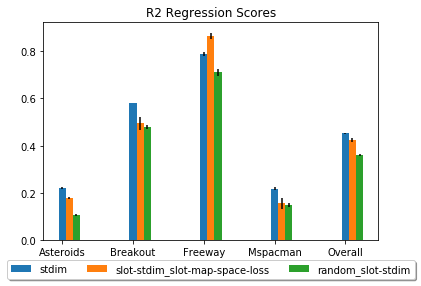

In [29]:
plot_bars(r2_m_df[methods], r2_stderr_df[methods], "R2 Regression Scores")

In [30]:
methods = list(fdf.columns) #["slot-stdim", "slot-stdim_slot-space-loss", "scn","slot-stdim_slot-map-space-loss"]
methods.remove("stdim")

In [32]:
dcid_df, count_df, dcid_mean_df, dcid_std_df = get_df(metric_name="r2_dci_d", tags="disentangle")

dcid_df = dcid_df.loc[["Asteroids","Freeway","Breakout","Mspacman"]][methods]
#print(tabulate.tabulate(dcid_df,headers=["env_name",*dcid_df.columns], tablefmt="pipe")) 
print(dcid_df.to_latex())

\begin{tabular}{lll}
\toprule
{} & slot-stdim\_slot-map-space-loss & random\_slot-stdim \\
\midrule
Asteroids &               0.016+-0.001 (3) &    0.002+-0.0 (2) \\
Freeway   &               0.022+-0.004 (3) &    0.003+-0.0 (3) \\
Breakout  &               0.015+-0.001 (3) &    0.011+-0.0 (2) \\
Mspacman  &               0.012+-0.001 (3) &    0.004+-0.0 (3) \\
\bottomrule
\end{tabular}



In [37]:
dcic_df, count_df, dcic_mean_df, dcic_std_df = get_df(metric_name="r2_dci_c", tags="disentangle")

dcic_df = dcic_df.loc[["Asteroids","Freeway","Breakout","Mspacman"]][methods]
#print(tabulate.tabulate(dcic_df,headers=["env_name",*dcic_df.columns], tablefmt="pipe")) 
print(dcic_df.to_latex())

\begin{tabular}{lll}
\toprule
{} & slot-stdim\_slot-map-space-loss & random\_slot-stdim \\
\midrule
Asteroids &                0.08+-0.039 (3) &    0.005+-0.0 (2) \\
Freeway   &               0.078+-0.031 (3) &  0.034+-0.015 (3) \\
Breakout  &               0.054+-0.029 (3) &  0.007+-0.001 (2) \\
Mspacman  &               0.026+-0.005 (3) &  0.007+-0.001 (3) \\
\bottomrule
\end{tabular}



In [9]:
#r2_methods = ["slot-stdim", "slot-stdim_slot-space-loss", "scn","stdim","slot-stdim_slot-map-space-loss", "random_slot-stdim" , "scn_loss1-only"]

In [10]:
# methods.remove("slot-stdim_slot-map-space-loss")


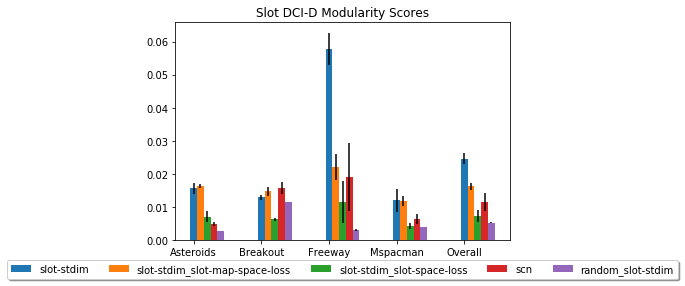

In [11]:
plot_bars(dcid_mean_df[methods], dcid_std_df[methods], "Slot DCI-D Modularity Scores")

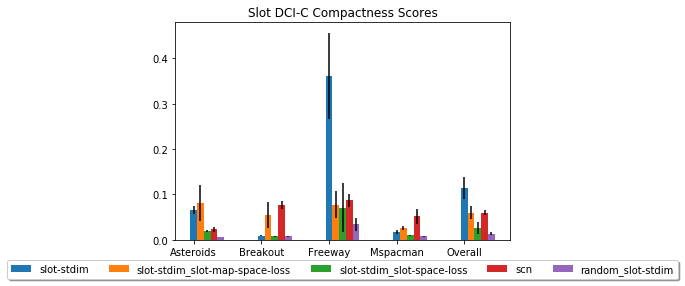

In [12]:
plot_bars(dcic_mean_df[methods], dcic_std_df[methods], "Slot DCI-C Compactness Scores")